In [6]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

2022-09-25 06:26:21.942197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 06:26:22.132971: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-25 06:26:22.782120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-25 06:26:22.782205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot 

In [2]:
df = pd.read_csv('DS_train.csv', sep = '\t') #ШТУКИ ЗАГРУЖАТЬ СЮДА

In [3]:
df.head()

,WebPriceId,DateObserve,StockStatus,CurrentPrice
0,1,2020-06-25 19:23:21.010,InStock,49.0
1,1,2020-09-08 07:39:23.593,OutOfStock,NaN
2,1,2020-09-08 15:39:01.663,InStock,49.0
3,1,2020-09-08 23:42:25.007,OutOfStock,NaN
4,1,2020-09-09 07:38:41.163,InStock,49.0


In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 300000

In [6]:
tf.random.set_seed(13)

In [7]:
uni_data = df['CurrentPrice']
uni_data.index = df['DateObserve']
uni_data.head()

DateObserve
2020-06-25 19:23:21.010    49.0
2020-09-08 07:39:23.593     NaN
2020-09-08 15:39:01.663    49.0
2020-09-08 23:42:25.007     NaN
2020-09-09 07:38:41.163    49.0
Name: CurrentPrice, dtype: float64

array([<AxesSubplot: xlabel='DateObserve'>], dtype=object)

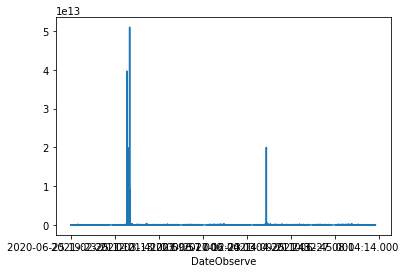

In [8]:
uni_data.plot(subplots=True)

In [10]:
uni_data = uni_data.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [11]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [12]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [13]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [14]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]

 Target temperature to predict
nan


In [15]:
def create_time_steps(length):
  return list(range(-length, 0))

In [16]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/home/jupyter-admin/.local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

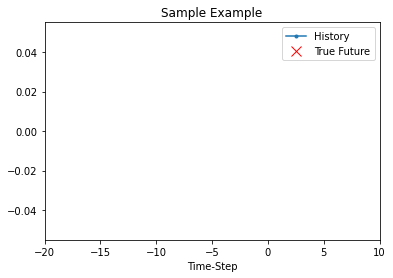

In [17]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [18]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

2022-09-25 06:39:27.250533: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-25 06:39:27.250595: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub-3b1e17b94eb738-jupyterhub-0): /proc/driver/nvidia/version does not exist
2022-09-25 06:39:27.252066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 06:39:27.303959: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11019818560 exceeds 10% of free system memory.


In [19]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [20]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

2022-09-25 06:39:54.402626: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11019818560 exceeds 10% of free system memory.


8/8 [==============================] - 0s 4ms/step
(256, 1)


In [21]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: nan

2022-09-25 06:40:12.152300: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11019818560 exceeds 10% of free system memory.


200/200 [==============================] - 11s 47ms/step - loss: nan - val_loss: nan
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: nan - val_loss: nan
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: nan - val_loss: nan
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: nan - val_loss: nan
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: nan - val_loss: nan
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: nan - val_loss: nan
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: nan - val_loss: nan
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: nan - val_loss: nan
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: nan - val_loss: nan
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: nan - val_loss: nan


2022-09-25 06:50:40.702314: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11019818560 exceeds 10% of free system memory.


8/8 [==============================] - 0s 3ms/step


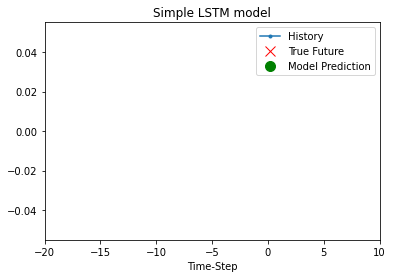

8/8 [==============================] - 0s 3ms/step


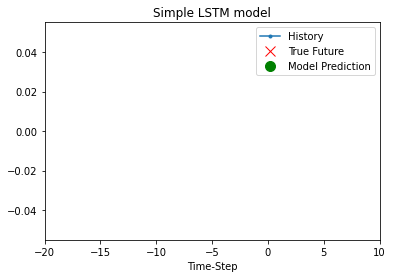

8/8 [==============================] - 0s 3ms/step


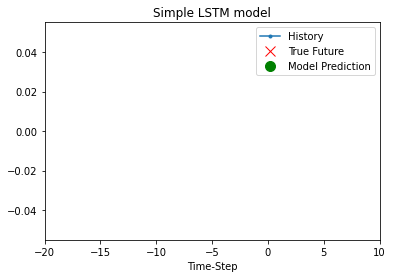

In [22]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()